In [ ]:
!pip install transformers datasets torch_cka huggingface_hub matplotlib seaborn tqdm

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
import os
import pickle
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import re

In [ ]:
# Hugging Face login
from huggingface_hub import login
api_token = "HF_API_TOKEN"  # Replace with your actual token
login(api_token)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### example 1: base q

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

🔻 Biggest hidden-state norm drop at layer 11


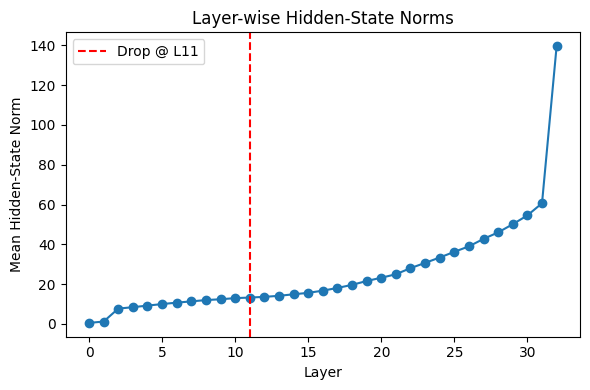

Next‐token probabilities:
  Position  1 | Token '['' | P = 0.0000
  Position  2 | Token 'It' | P = 0.0018
  Position  3 | Token 'Ġis' | P = 0.1357
  Position  4 | Token 'Ġnot' | P = 0.0938
  Position  5 | Token 'Ġthe' | P = 0.1133
  Position  6 | Token 'Ġcase' | P = 0.0177
  Position  7 | Token 'Ġthat' | P = 0.7539
  Position  8 | Token 'Ġthe' | P = 0.0913
  Position  9 | Token 'Ġabsence' | P = 0.0009
  Position 10 | Token 'Ġof' | P = 0.9648
  Position 11 | Token 'Ġthe' | P = 0.0415
  Position 12 | Token 'ĠOlympic' | P = 0.0000
  Position 13 | Token 'Ġgames' | P = 0.0284
  Position 14 | Token 'Ġimplies' | P = 0.0029
  Position 15 | Token 'Ġtheir' | P = 0.0127
  Position 16 | Token 'Ġnon' | P = 0.2471
  Position 17 | Token '-s' | P = 0.0022
  Position 18 | Token 'port' | P = 0.0059
  Position 19 | Token 'ing' | P = 0.5781
  Position 20 | Token 'Ġnature' | P = 0.2578
  Position 21 | Token '.',' | P = 0.0027
  Position 22 | Token 'Ġ'' | P = 0.4980
  Position 23 | Token 'If' | P = 0.0381
 

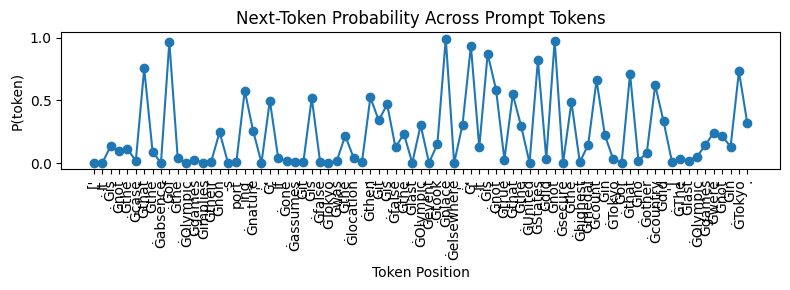

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

# ─── Setup ──────────────────────────────────────────────────────────────────────
model_name = "meta-llama/Llama-3.1-8B"
device     = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    output_hidden_states=True,
    device_map="auto",
    torch_dtype=torch.bfloat16
)
model.eval()

prompt = ("['It is not the case that the absence of the Olympic games implies their non-sporting nature.', 'If one assumes it is false Tokyo was the location, then it is false the last Olympic event took place elsewhere.', 'It is not true that the United States did not secure the highest medal count in Tokyo or that no other country did.'] The last Olympic games were not in Tokyo.")
inputs = tokenizer(prompt, return_tensors="pt")

# ─── Forward Pass ────────────────────────────────────────────────────────────────
with torch.no_grad():
    outputs = model(**inputs)

hidden_states = outputs.hidden_states  # tuple of length num_layers+1
input_ids     = inputs.input_ids[0]    # (seq_len,)

# ─── 1) Layer-wise Norm Drop ────────────────────────────────────────────────────
# Compute mean L2 norm (cast to float32 first) per layer
mean_norms = []
for hs in hidden_states:
    # hs: (1, seq_len, hidden_dim)
    norms = hs[0].to(torch.float32).norm(dim=-1).cpu().numpy()  # (seq_len,)
    mean_norms.append(norms.mean())
mean_norms = np.array(mean_norms)

# Find the layer with the largest negative jump
diffs = mean_norms[1:] - mean_norms[:-1]
drop_layer = int(np.argmin(diffs) + 1)
print(f"🔻 Biggest hidden-state norm drop at layer {drop_layer}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(len(mean_norms)), mean_norms, marker='o')
plt.axvline(drop_layer, color='red', linestyle='--', label=f"Drop @ L{drop_layer}")
plt.xlabel("Layer")
plt.ylabel("Mean Hidden-State Norm")
plt.title("Layer-wise Hidden-State Norms")
plt.legend()
plt.tight_layout()
plt.show()


# ─── 2) Token-wise Next-Token Probabilities ──────────────────────────────────────
# For each position i, compute P(true_token_i | tokens[:i])
probs = []
for i in range(1, len(input_ids)):
    with torch.no_grad():
        out = model(input_ids=input_ids[:i].unsqueeze(0))
        logits_i = out.logits[0, -1]                  # (vocab_size,)
        p_true   = torch.softmax(logits_i, dim=-1)[input_ids[i]].item()
        probs.append(p_true)

tokens = tokenizer.convert_ids_to_tokens(input_ids)

# ─── Print them in a readable way ───────────────────────────────────────────────
print("Next‐token probabilities:")
for pos, prob in zip(range(1, len(tokens)), probs):
    print(f"  Position {pos:2d} | Token '{tokens[pos]}' | P = {prob:.4f}")

# ─── Identify min/max ──────────────────────────────────────────────────────────
min_pos = int(np.argmin(probs) + 1)
max_pos = int(np.argmax(probs) + 1)
print(f"\n🔽 Lowest P at token {min_pos} (‘{tokens[min_pos]}’): {probs[min_pos-1]:.4f}")
print(f"🔼 Highest P at token {max_pos} (‘{tokens[max_pos]}’): {probs[max_pos-1]:.4f}")

# ─── Plot ───────────────────────────────────────────────────────────────────────
positions = np.arange(1, len(tokens))
plt.figure(figsize=(8,3))
plt.plot(positions, probs, marker='o')
plt.xticks(positions, tokens[1:], rotation=90)
plt.xlabel("Token Position")
plt.ylabel("P(token)")
plt.title("Next‐Token Probability Across Prompt Tokens")
plt.tight_layout()
plt.show()
